In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, learning_curve
from pycaret.classification import *
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv("Fraud.csv")

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Data cleaning 

In [5]:
print("Missing Values")
df.isnull().sum()

Missing Values


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Checking if data is balanced or not

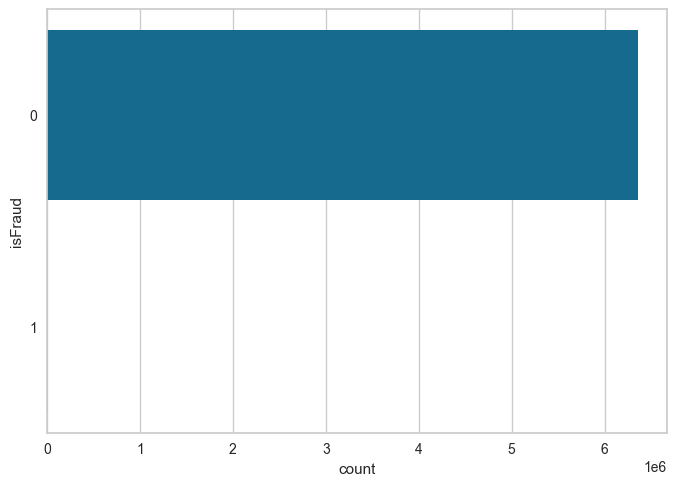

In [6]:
sns.countplot(y = df['isFraud'])
plt.show()

<AxesSubplot: xlabel='isFraud', ylabel='Count'>

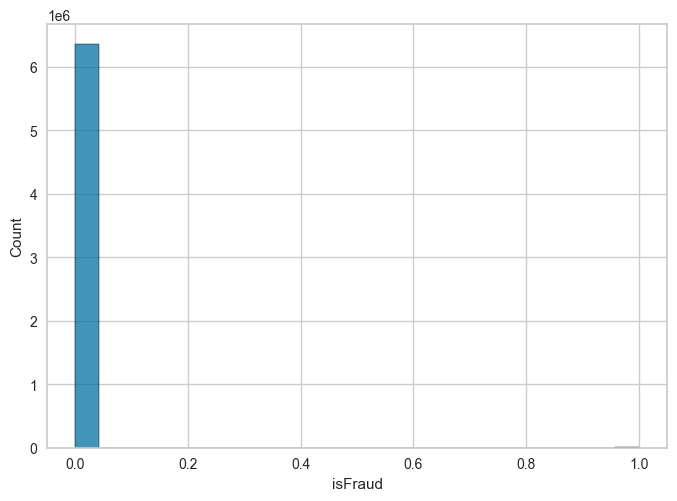

In [7]:
sns.histplot(x=df['isFraud'])

<AxesSubplot: xlabel='isFlaggedFraud', ylabel='Count'>

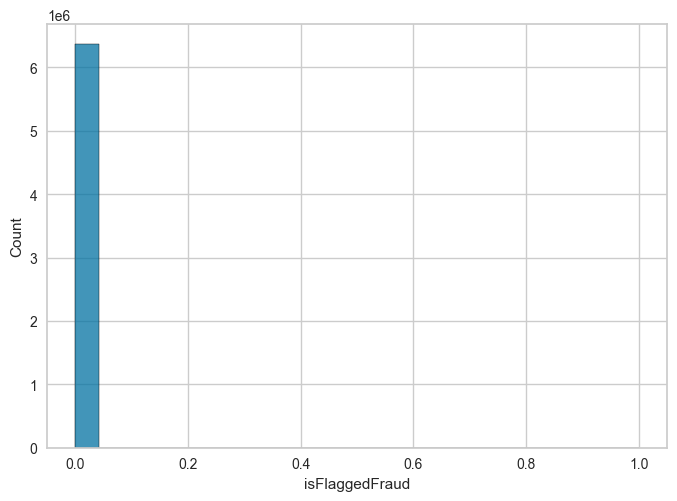

In [8]:
sns.histplot(x=df['isFlaggedFraud'])

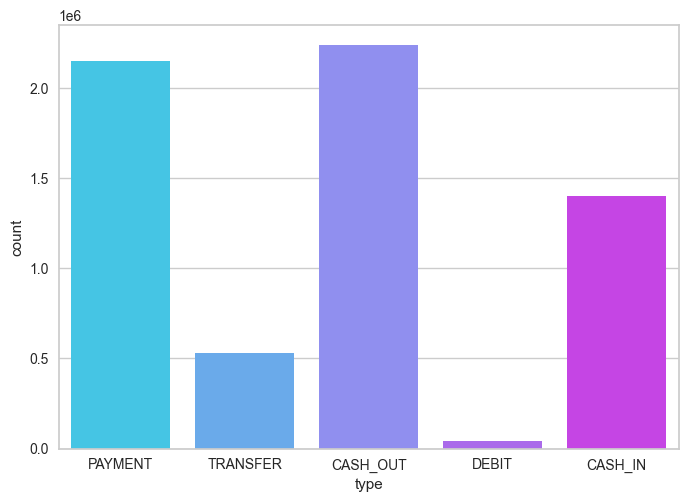

In [9]:
sns.countplot(x='type', data=df, palette='cool')
plt.show()

In [10]:
df = pd.get_dummies(df, columns=['type'])

# Checking for multicollinearity and fixing it

<AxesSubplot: >

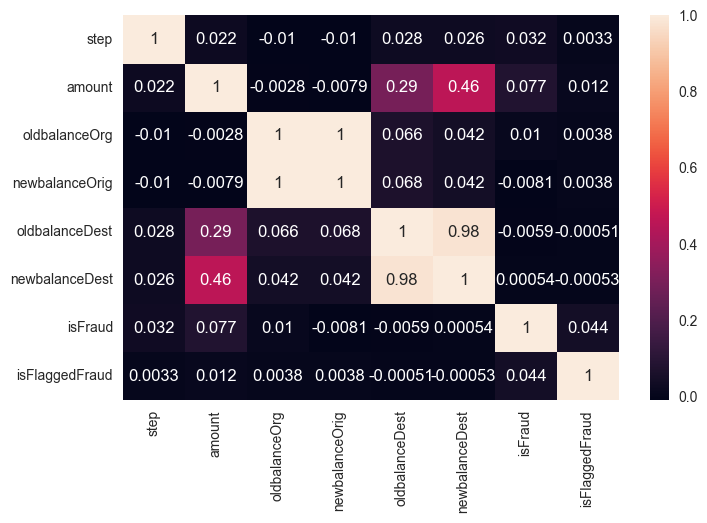

In [11]:
plt.figure(figsize=(8,5))
sns.heatmap(df.select_dtypes(['int64','float64']).corr(),annot=True)

In [12]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [13]:
fraud = df[df['isFraud'] == 1]

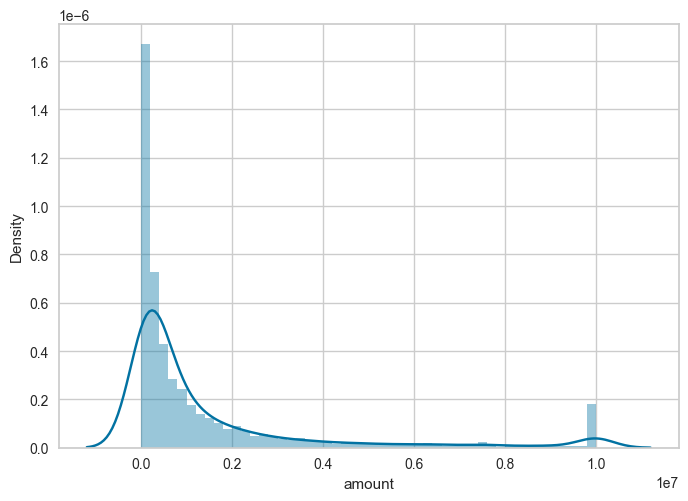

In [14]:
sns.distplot(fraud['amount']);

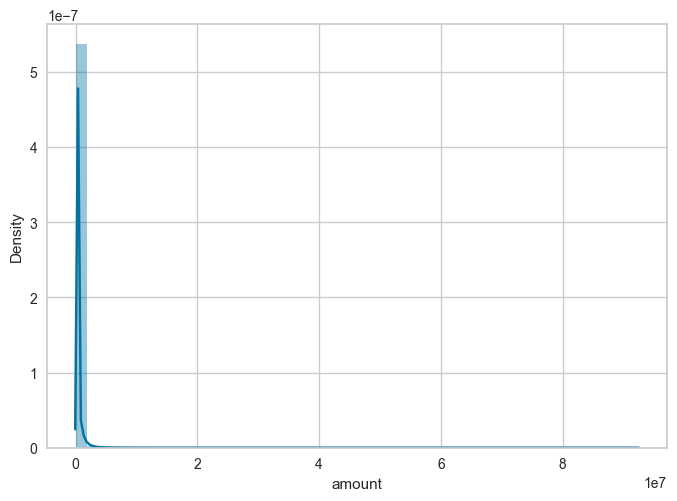

In [15]:
sns.distplot(df['amount'])
plt.show()

In [16]:
df['balanceOrg']=df['oldbalanceOrg']-df['newbalanceOrig']
df['balanceDest']=df['oldbalanceDest']-df['newbalanceDest']
df.drop(['oldbalanceDest','oldbalanceOrg','newbalanceOrig','newbalanceDest'],axis=1,inplace=True)

In [17]:
le = LabelEncoder()
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])

step


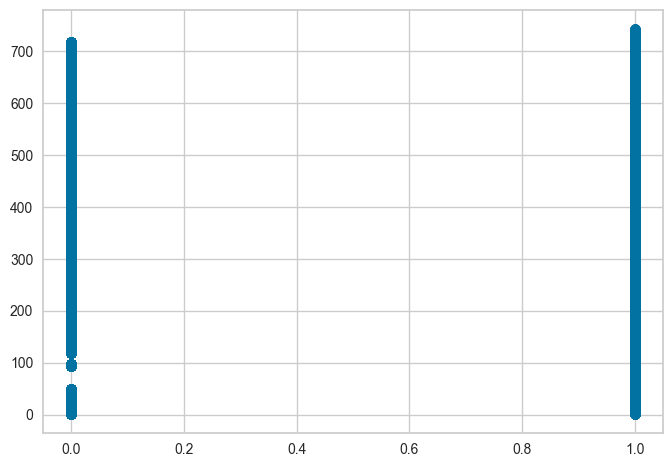

amount


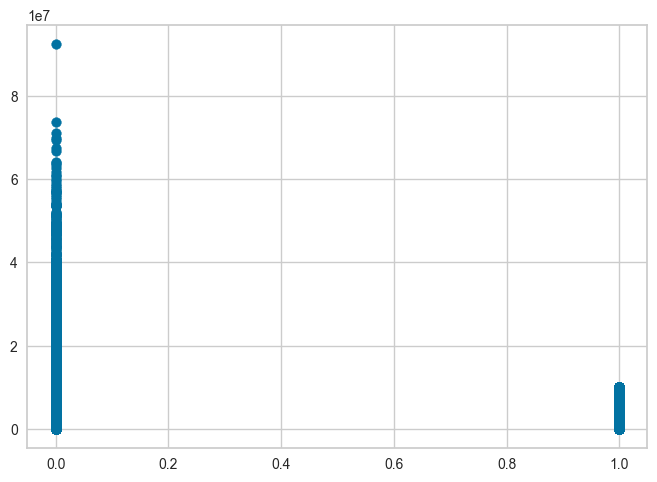

balanceOrg


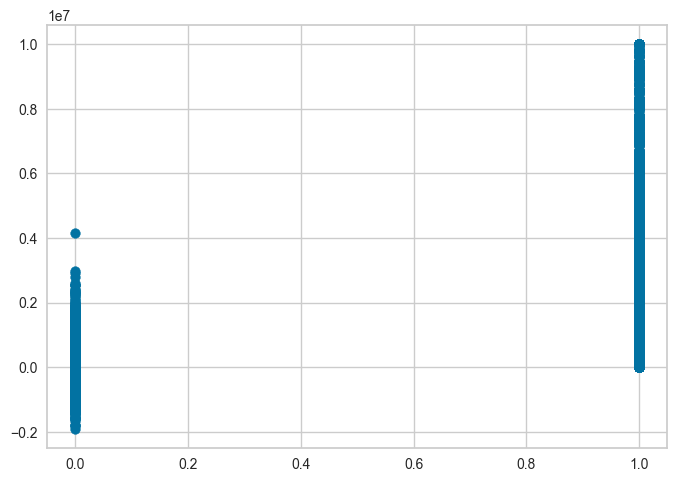

balanceDest


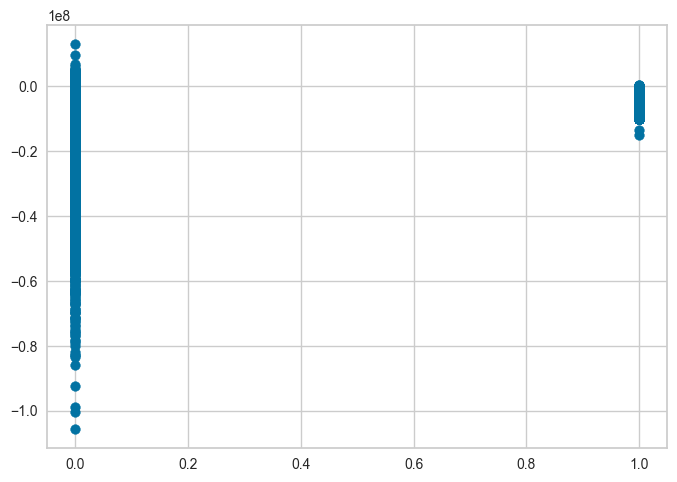

In [18]:
col = ['step', 'amount','balanceOrg','balanceDest']
for i in col:
    print(i)
    plt.scatter(df['isFraud'], df[i])
    plt.show()

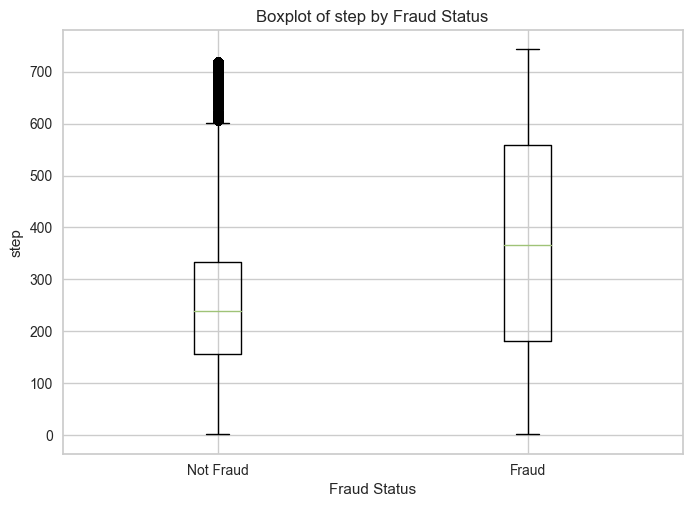

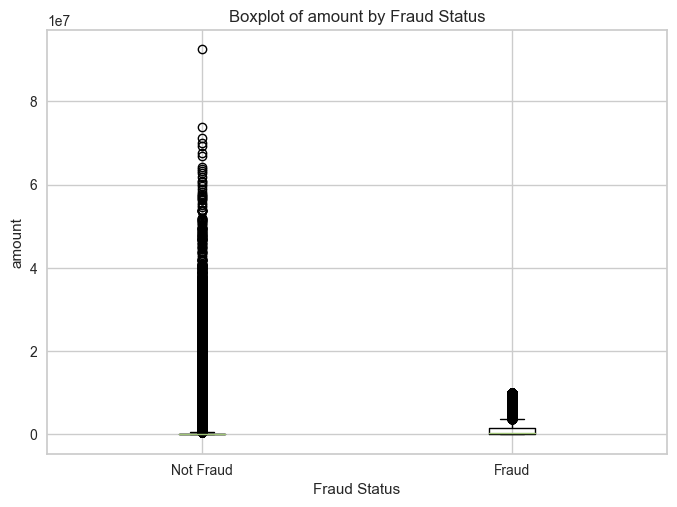

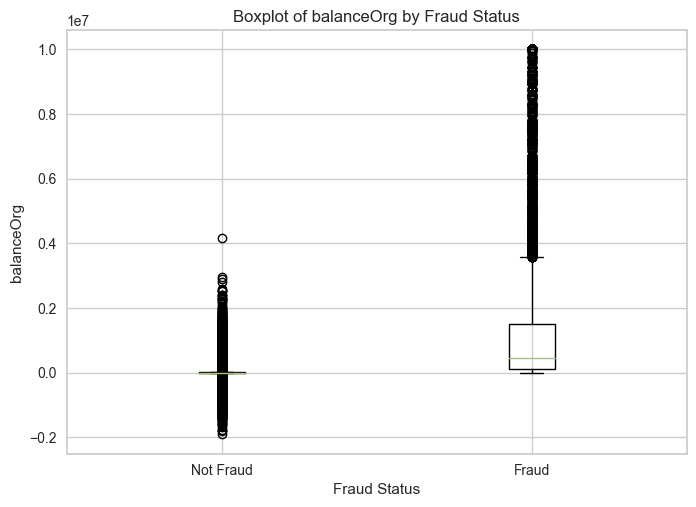

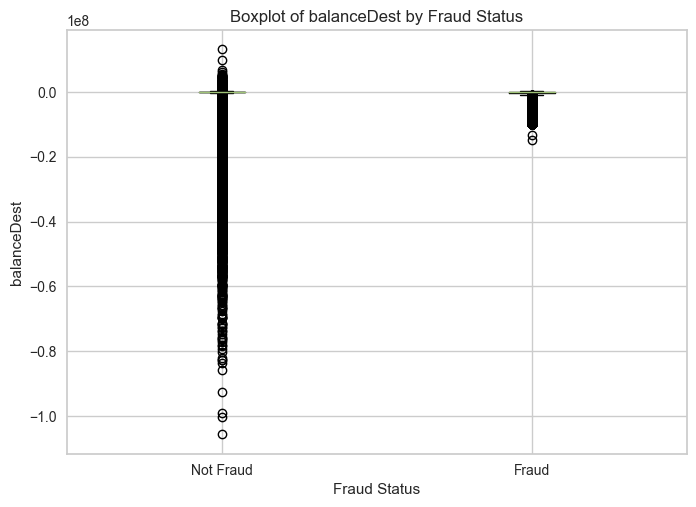

In [19]:
col = ['step', 'amount', 'balanceOrg', 'balanceDest']

for i in col:
    plt.boxplot([df[df['isFraud'] == 0][i], df[df['isFraud'] == 1][i]], labels=['Not Fraud', 'Fraud'])
    plt.title(f'Boxplot of {i} by Fraud Status')
    plt.xlabel('Fraud Status')
    plt.ylabel(i)
    plt.show()

In [20]:
num_col = ['step', 'amount', 'balanceOrg', 'balanceDest']
outliers_count = {}

for col in num_col:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    outliers = ((df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr)))
    
    n_outliers = outliers.sum()
    outliers_count[col] = n_outliers
    
for col, count in outliers_count.items():
    print(f"Number of outliers in column '{col}': {count}")


Number of outliers in column 'step': 102688
Number of outliers in column 'amount': 338078
Number of outliers in column 'balanceOrg': 2139299
Number of outliers in column 'balanceDest': 886695


In [21]:
columns_to_zscore = ['step', 'amount', 'balanceOrg', 'balanceDest']

z_scores = np.abs(stats.zscore(df[columns_to_zscore]))
filtered_entries = (z_scores < 3).all(axis=1)
df = df[filtered_entries]
df

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balanceOrg,balanceDest
0,1,9839.64,757869,1662094,0,0,0,0,0,1,0,9839.64,0.0
1,1,1864.28,2188998,1733924,0,0,0,0,0,1,0,1864.28,0.0
2,1,181.00,1002156,439685,1,0,0,0,0,0,1,181.00,0.0
3,1,181.00,5828262,391696,1,0,0,1,0,0,0,181.00,21182.0
4,1,11668.14,3445981,828919,0,0,0,0,0,1,0,11668.14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295995,670,8868.80,2096973,1953514,0,0,0,0,0,1,0,8868.80,0.0
6295996,670,7343.33,6003247,1784922,0,0,0,0,0,1,0,152.00,0.0
6295997,670,3282.37,1690625,1362068,0,0,0,0,0,1,0,3282.37,0.0
6295998,670,4527.98,1270341,1305682,0,0,0,0,0,1,0,2671.63,0.0


In [22]:
df_train, df_test = train_test_split(df, random_state =100 , test_size = 0.3)

In [23]:
setup_df = setup(data= df_train, target = 'isFraud', 
                 session_id=100, data_split_stratify=True, 
                 remove_outliers=True)

,Description,Value
0,Session id,100
1,Target,isFraud
2,Target type,Binary
3,Original data shape,"(4337389, 13)"
4,Transformed data shape,"(4185580, 13)"
5,Transformed train set shape,"(2884363, 13)"
6,Transformed test set shape,"(1301217, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


# visualizing data for better understanding

In [24]:
def calculate_vif(df):
    features = df.drop(columns=['isFraud'])
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return vif_data

vif_result = calculate_vif(df_train)
print("VIF Results:")
print(vif_result)

VIF Results:
          Variable       VIF
0             step  1.006839
1           amount  4.601920
2         nameOrig  1.000002
3         nameDest  3.780292
4   isFlaggedFraud  1.000037
5     type_CASH_IN  3.971573
6    type_CASH_OUT  3.958806
7       type_DEBIT  1.044650
8     type_PAYMENT  9.324364
9    type_TRANSFER  2.590416
10      balanceOrg  3.359490
11     balanceDest  5.044798


In [25]:
threshold = 5
high_vif_variables = vif_result[vif_result["VIF"] > threshold]["Variable"].tolist()
df_train_no_high_vif = df_train.drop(columns=high_vif_variables)
print(f"Variables removed due to high VIF: {high_vif_variables}")

Variables removed due to high VIF: ['type_PAYMENT', 'balanceDest']


Correlation matrix:


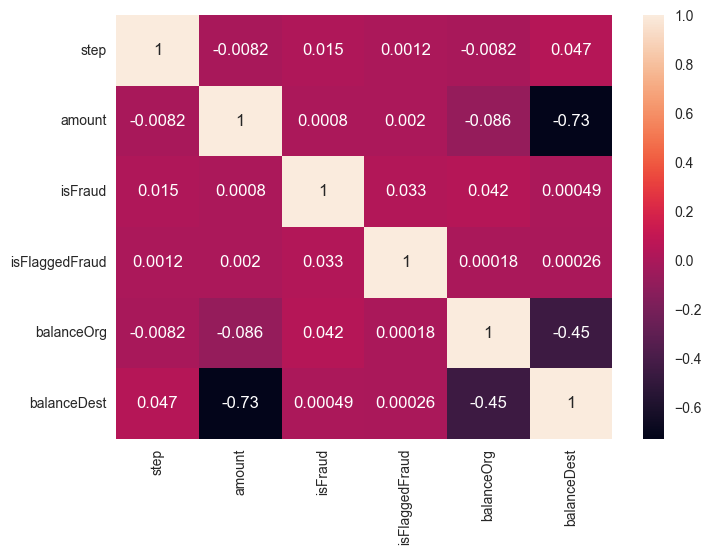

In [26]:
print("Correlation matrix:")
sns.heatmap(df.select_dtypes(['int64','float64']).corr(),annot=True)
plt.show()

In [27]:
print("VIF Results:")
print(vif_result)

threshold = 5
high_vif_variables = vif_result[vif_result["VIF"] > threshold]["Variable"].tolist()
df_train_no_high_vif = df_train.drop(columns=high_vif_variables)
print(f"Variables removed due to high VIF: {high_vif_variables}")

VIF Results:
          Variable       VIF
0             step  1.006839
1           amount  4.601920
2         nameOrig  1.000002
3         nameDest  3.780292
4   isFlaggedFraud  1.000037
5     type_CASH_IN  3.971573
6    type_CASH_OUT  3.958806
7       type_DEBIT  1.044650
8     type_PAYMENT  9.324364
9    type_TRANSFER  2.590416
10      balanceOrg  3.359490
11     balanceDest  5.044798
Variables removed due to high VIF: ['type_PAYMENT', 'balanceDest']


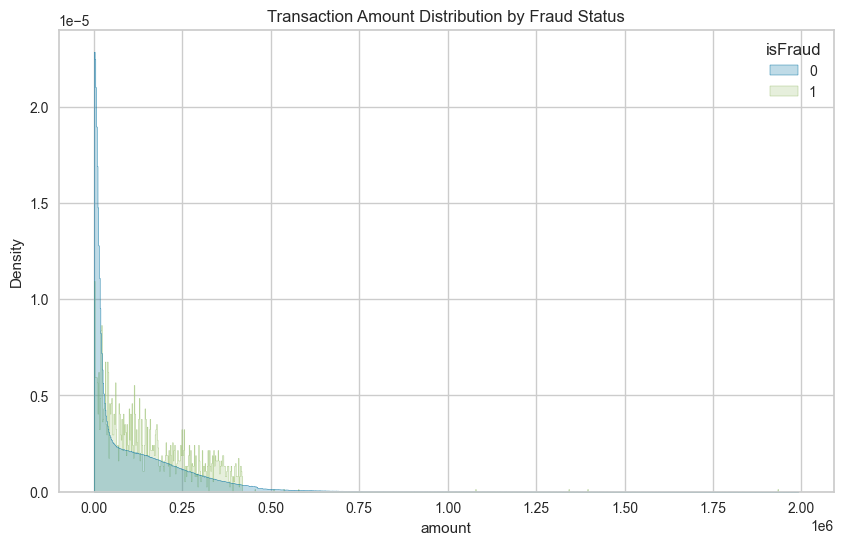

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='amount', hue='isFraud', element='step', stat='density', common_norm=False)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.show()

I'm using XGBoost for fraud detection because it's great with both categorical and numerical data. It's fast, flexible, and handles large datasets well, making it ideal for identifying different patterns in complex financial data. Plus, it's robust against overfitting and can be fine-tuned for optimal performance.

In [29]:
import xgboost as xgb

In [30]:
xgb = create_model("xgboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9997,0.9954,0.4831,0.9663,0.6442,0.6441,0.6832
1,0.9996,0.9949,0.4157,0.9024,0.5692,0.5691,0.6124
2,0.9997,0.9882,0.4463,0.9518,0.6077,0.6075,0.6517
3,0.9997,0.9937,0.4689,0.9540,0.6288,0.6286,0.6687
4,0.9996,0.9939,0.4181,0.9487,0.5804,0.5802,0.6297
5,0.9997,0.9921,0.5254,0.9208,0.6691,0.6689,0.6954
6,0.9997,0.9950,0.4438,0.9875,0.6124,0.6123,0.6619
7,0.9997,0.9951,0.4888,0.9255,0.6397,0.6396,0.6725
8,0.9997,0.9943,0.4551,0.9000,0.6045,0.6043,0.6398


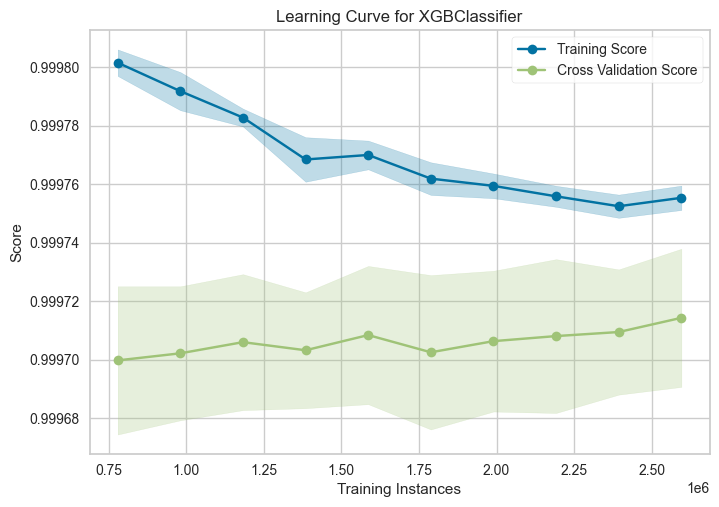

In [31]:
plot_model(estimator = xgb , plot= "learning")

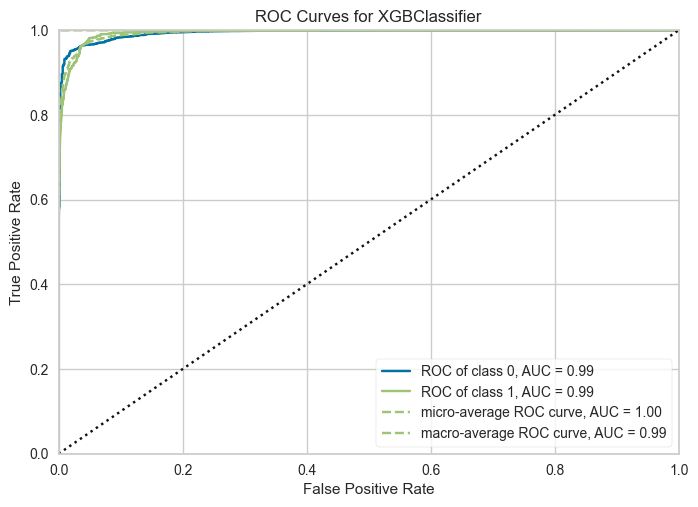

In [32]:
plot_model(estimator = xgb , plot= "auc")

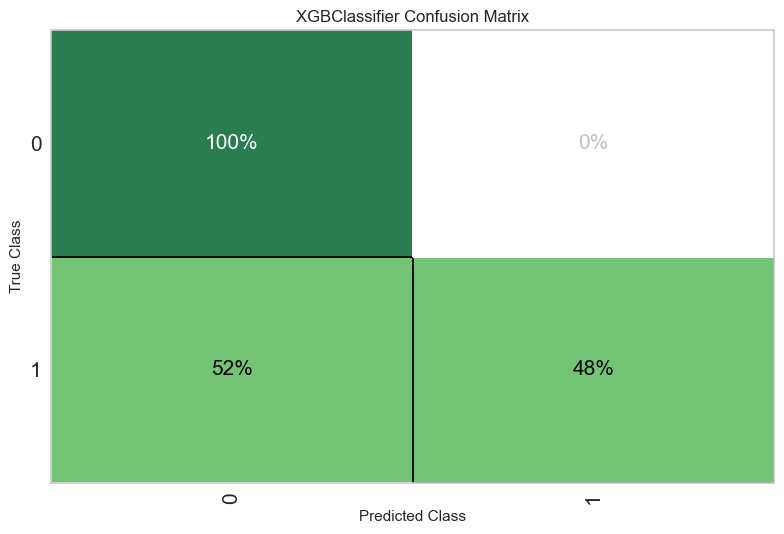

In [33]:
plot_model(estimator = xgb , plot= "confusion_matrix", plot_kwargs = {'percent' : True})

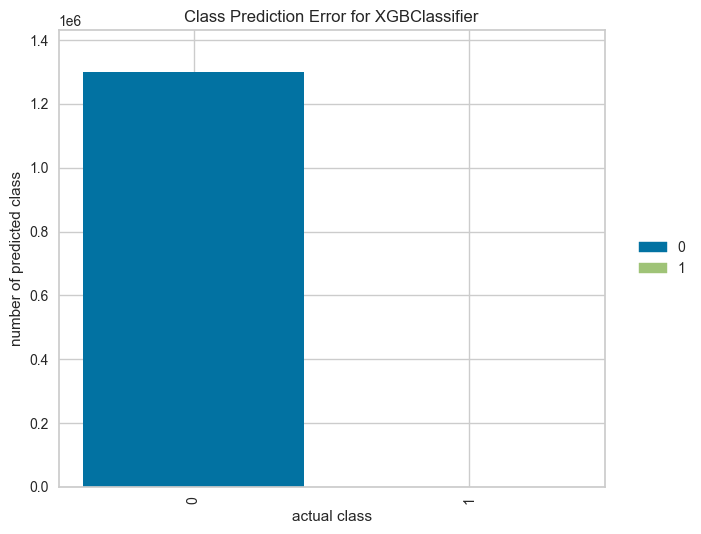

In [34]:
plot_model(estimator = xgb, plot = "error")

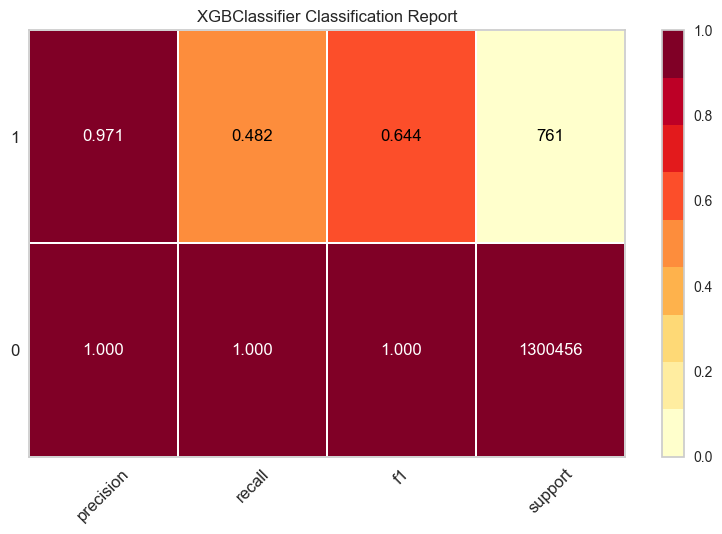

In [35]:
plot_model(estimator = xgb, plot = "class_report")

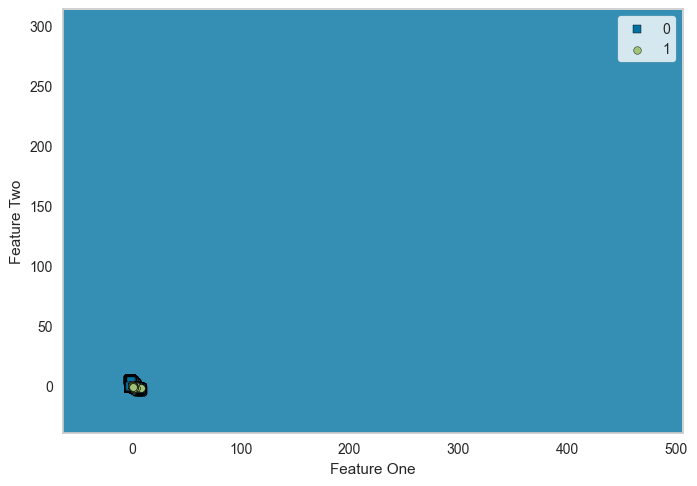

In [36]:
plot_model(estimator = xgb, plot = "boundary")

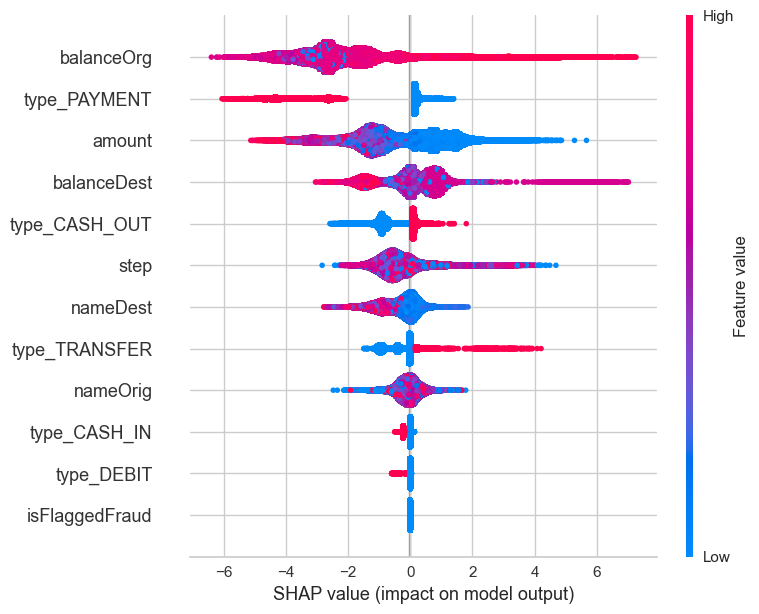

In [37]:
interpret_model(xgb)

In [38]:
predict_model(xgb);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9997,0.9940,0.4823,0.9709,0.6444,0.6443,0.6842


In [39]:
pred = predict_model(xgb, data=df_test)
pred.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9997,0.9937,0.5227,0.9447,0.6730,0.6729,0.7026


,step,amount,nameOrig,nameDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balanceOrg,balanceDest,isFraud,prediction_label,prediction_score
5852700,402,20760.289062,3542839,2644304,0,0,0,0,1,0,0.0000,0.00000,0,0,1.0
1780295,162,440311.562500,1801912,451455,0,0,0,0,0,1,0.0000,-440311.59375,0,0,1.0
4355381,309,206599.062500,4849428,172806,0,1,0,0,0,0,-206599.0625,0.00000,0,0,1.0
3439456,257,10793.160156,1867876,2145669,0,0,0,0,1,0,437.0000,0.00000,0,0,1.0
1990543,179,1469.270020,5843484,1414126,0,0,0,0,1,0,1434.0000,0.00000,0,0,1.0


In [40]:
accuracy = accuracy_score(pred['isFraud'], pred['prediction_label'])
print("Accuracy score:", accuracy)

Accuracy score: 0.9997051989879933


# Demonstrate the performance of the model by using best set of tools.

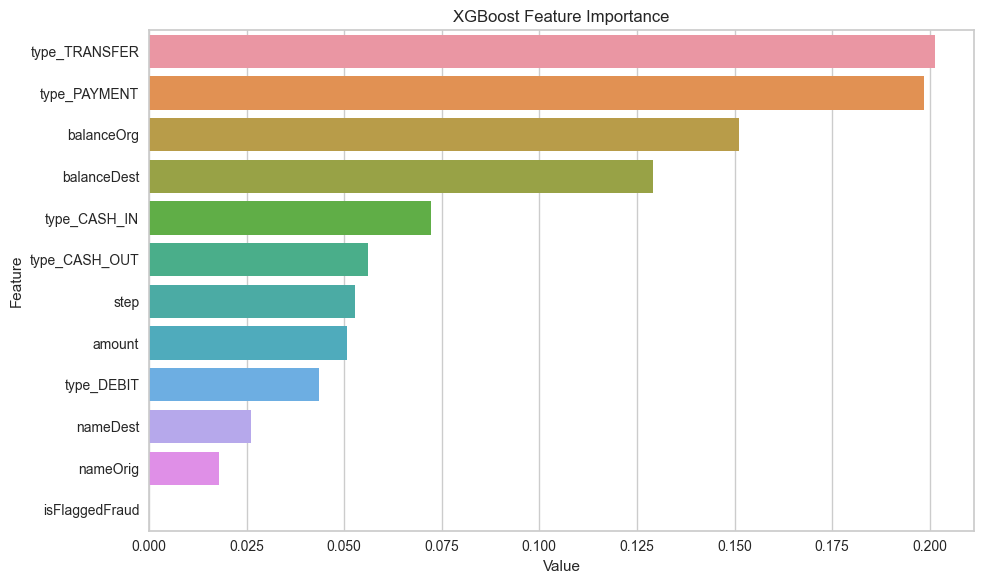

In [41]:
feature_names = df_train.drop(columns=['isFraud']).columns
feature_imp = pd.DataFrame({
    'Value': xgb.feature_importances_,
    'Feature': feature_names
})

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

In [42]:
scores = cross_val_score(xgb, df_train.drop('isFraud', axis=1), df_train['isFraud'], cv=5)
print("Cross-validated scores:", scores)

Cross-validated scores: [0.99967838 0.99970143 0.99967723 0.99971066 0.99967607]


In [43]:
y_pred = xgb.predict(df_test.drop('isFraud', axis=1))
print(classification_report(df_test['isFraud'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1857802
           1       0.94      0.52      0.67      1079

    accuracy                           1.00   1858881
   macro avg       0.97      0.76      0.84   1858881
weighted avg       1.00      1.00      1.00   1858881



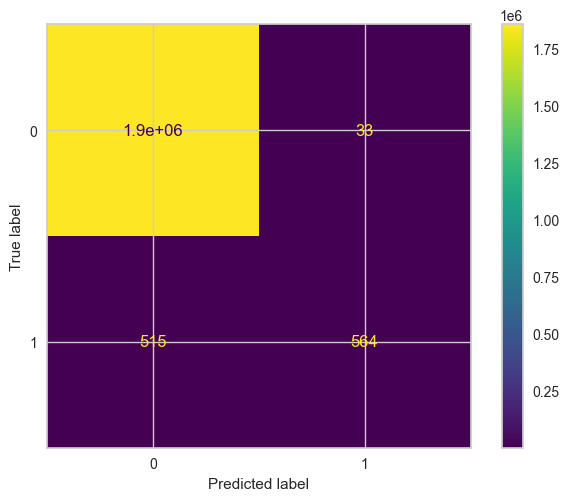

In [44]:
cm = confusion_matrix(df_test['isFraud'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

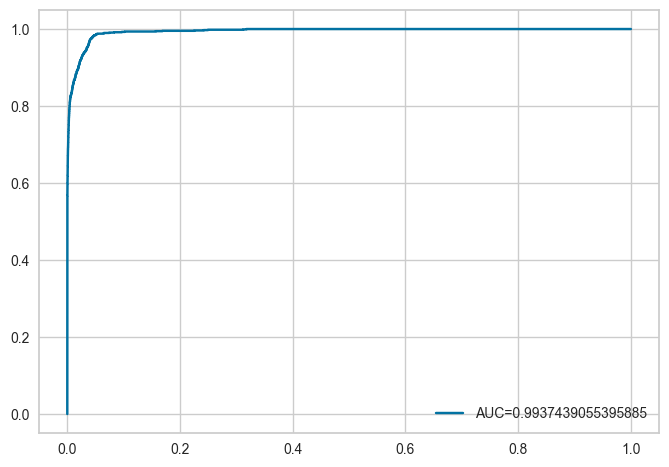

In [45]:
y_pred_proba = xgb.predict_proba(df_test.drop('isFraud', axis=1))[::,1]
fpr, tpr, _ = roc_curve(df_test['isFraud'],  y_pred_proba)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

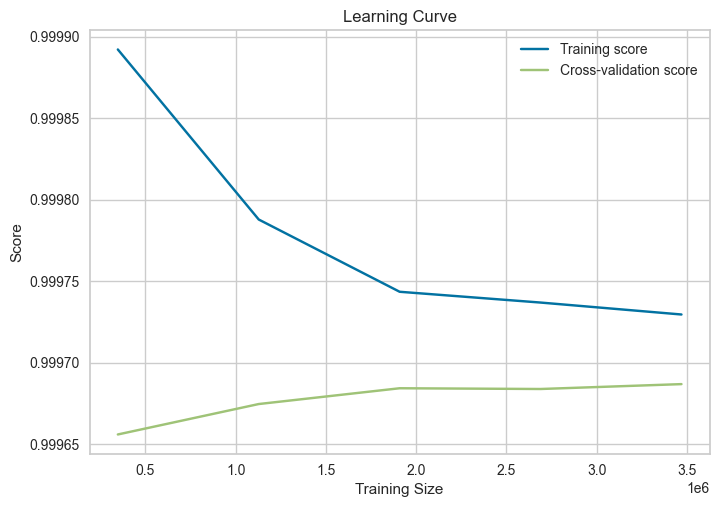

In [46]:
train_sizes, train_scores, test_scores = learning_curve(xgb, df_train.drop('isFraud', axis=1), df_train['isFraud'], cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

In [47]:
df_test.columns

Index(['step', 'amount', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'balanceOrg', 'balanceDest'],
      dtype='object')

How did you select variables to be included in the model?

Ans:To select variables for the model, I first identified relevant features, like transaction amounts and account balances, crucial for detecting fraud. I then handled missing values and encoded categorical variables into numerical format. To avoid multicollinearity, I used a heatmap and Variance Inflation Factor (VIF) to identify and remove highly correlated features. Finally, I filtered out outliers to prevent them from skewing the model's accuracy, aiming for a balance between informative features and model simplicity.

What are the key factors that predict fraudulent customer?

Ans:
1. Step('step')
2. Amount('amount')
3. type of transaction('type')
4. Account balance('balanceorg','balanceDest')
    

In [48]:
df_test.columns

Index(['step', 'amount', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'balanceOrg', 'balanceDest'],
      dtype='object')

Do these factors make sense? If yes, How? If not, How not?
Ans:
Yes, these factors make sense for detecting fraud. To identify the key factors that predict a fraudulent customer, I analyzed the feature importances of the model, specifically the XGBoost classifier. Feature importance gives a sense of which variables are most influential in predicting whether a transaction is fraudulent.Here are some potential key factors:
1. Step('step'):
It represents the unit of time, which is useful to identify if there any pattern in fraudulent transactions
2. Amount('amount'):
Large or unusual transaction amounts can represent the fraudulent activity.
3. type of transaction('type'):
Certain type of tansaction can interpret the susceptible to fraud.
4. Account balance('balanceorg','balanceDest'):
Major differences in account balances before and after the transaction may suscept fraud.    

What kind of prevention should be adopted while company update its infrastructure?
Ans:
1. Be Aware of Traditional Scams: 
Keep an eye out for common scams, as they often evolve and reappear.
2. Implement Two-Factor Authentication and Challenge Questions: 
Require additional authentication methods for logins and certain transactions for added security.
3. Use Longer Passwords: 
Encourage users to use of complex and longer passwords over frequent changes.
4. Fraud Monitoring System:
Implement a robust system in our online banking platform to detect suspicious activities.
5. Alert Customers of Suspicious Activity: 
Frequently inform customers about any unusual transactions in their accounts.


To evaluate if our implemented measures are effective, I'd take a hands-on approach:

1. Monitoring for Traditional Scams: 
I'd keep a close watch on scam patterns, looking for reductions in known scam activities and staying alert for their new variations.

2. Assessing Two-Factor Authentication and Challenge Questions: 
I'd analyze login and transaction data to ensure these added layers are being used effectively and reducing unauthorized access.

3. Evaluating Password Policies: 
I'd review password strength across user accounts to confirm an increase in the use of longer, more complex passwords.

4. Fraud Monitoring System Effectiveness: 
I'd analyze the performance of our fraud detection system, looking for an increased rate of detected and prevented fraudulent activities.

5. Customer Feedback on Alerts: 
I'd gather feedback from customers on the alerts they receive for unusual activities to ensure they're timely, clear, and actionable.

Regularly reviewing these aspects will help me understand how well our measures are working and where we need to make adjustments for better fraud prevention.